In [1]:
from pinkribbon.dataset import ZipImageDataLoader
from pinkribbon.images import MedImage
from pinkribbon.plots import *
import seaborn as sns

2025-08-04 14:05:44.689511: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 14:05:44.704957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754309144.717113   47744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754309144.720502   47744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754309144.732012   47744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
dataloader = ZipImageDataLoader("../data/BHI.zip")

In [3]:
MedImage.open_zfile("../data/BHI.zip")

In [4]:
dataloader[0]

(<pinkribbon.images.MedImage at 0x7f5c2c9068d0>, 0)

In [5]:
dataloader[0][0].array.shape

(50, 50, 3)

# Analyse 

## Nombre d'images

In [6]:
nb_images = len(dataloader)
nb_images

277524

## Targets

In [7]:
targets = dataloader.classes

In [8]:
targets

array([0, 0, 0, ..., 1, 1, 1])

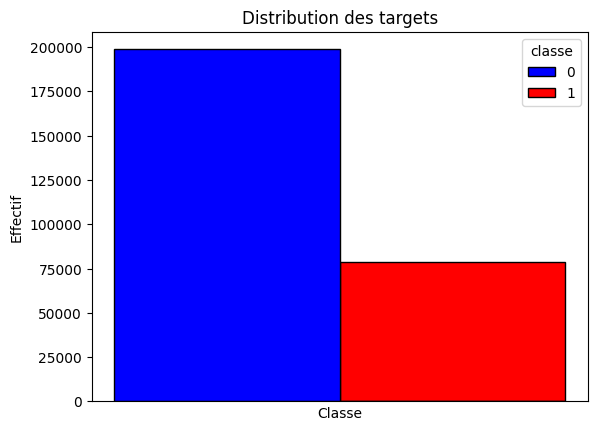

In [9]:
palette = {0: 'blue', 1: 'red'}
g = sns.histplot({"classe":targets},x="classe",discrete=True, hue="classe",palette=palette, alpha=1)
g.set_xlabel("Classe")
g.set_ylabel("Effectif")
g.set_xticklabels([])
g.set_xticks([])
g.set_title("Distribution des targets");

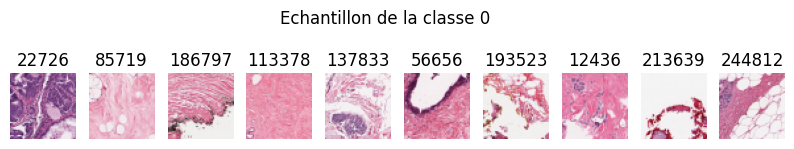

In [10]:
sample_0 =  plot_sample(dataloader,10, 0, seed=42)

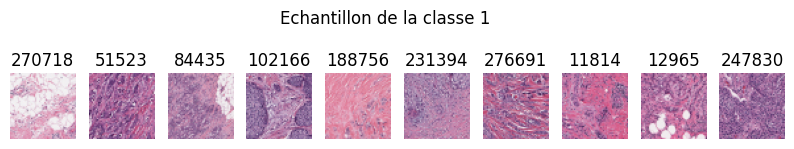

In [11]:
sample_1 =  plot_sample(dataloader, 10, 1, seed=42)

In [12]:
sample = list(sample_0.values())[1][0].array

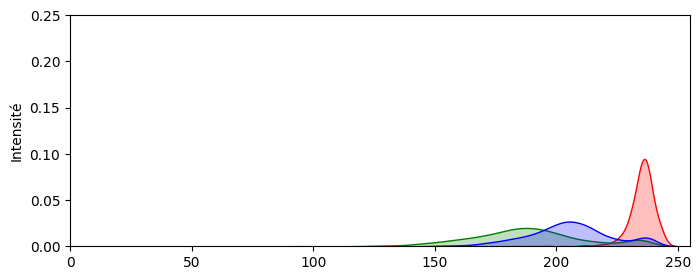

In [13]:
get_specter(sample)

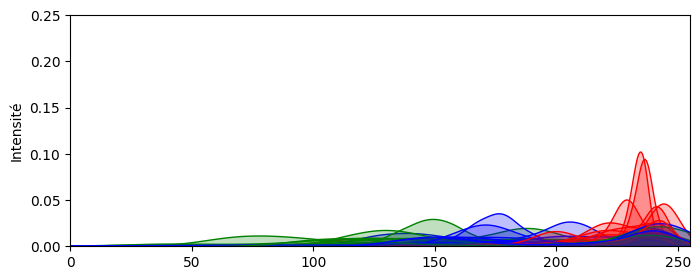

In [14]:
get_overlaped_specter(sample_0)

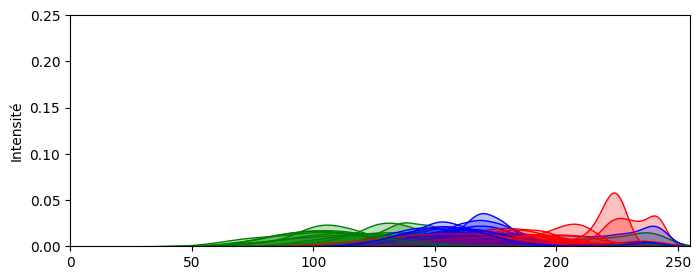

In [15]:
get_overlaped_specter(sample_1)

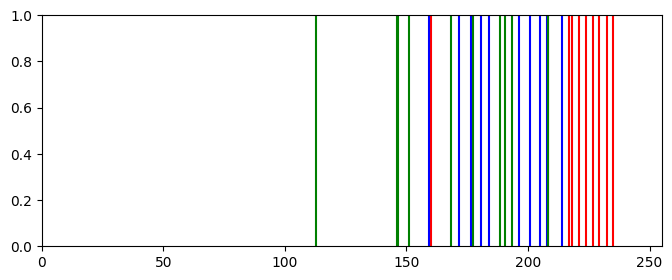

In [16]:
get_overlaped_mean_specter(sample_0)

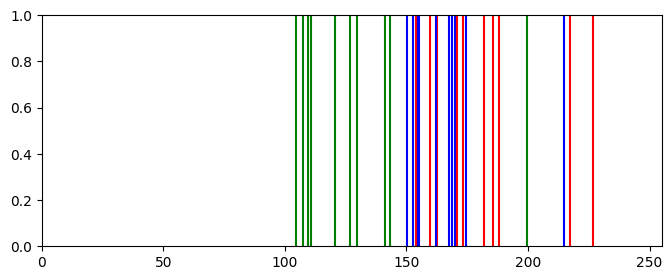

In [17]:
get_overlaped_mean_specter(sample_1)

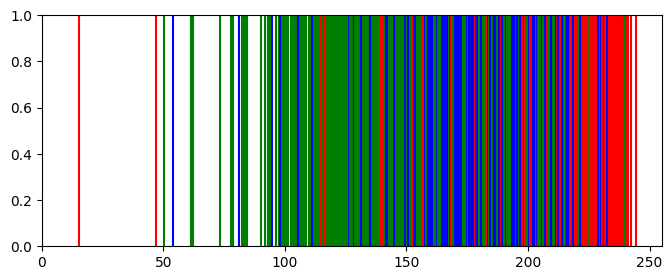

In [18]:
sample = dataloader.get_sample(1000,0)
get_overlaped_mean_specter(sample)

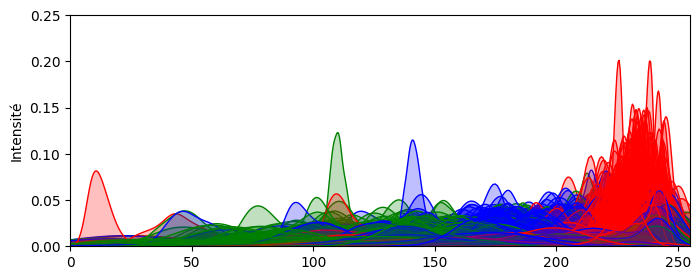

In [19]:
get_overlaped_specter(sample)

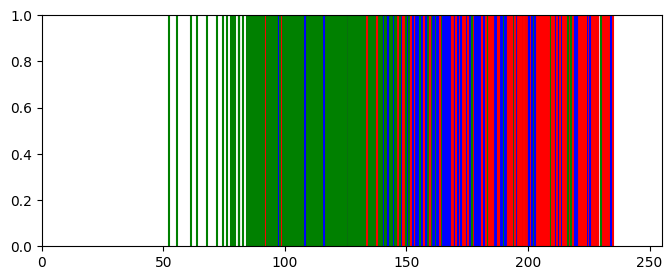

In [20]:
sample = dataloader.get_sample(1000,1)
get_overlaped_mean_specter(sample)

# Prétraitements

## Le CLAHE

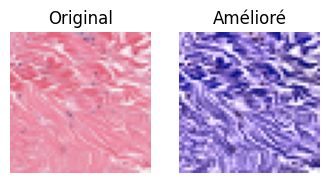

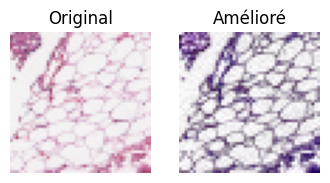

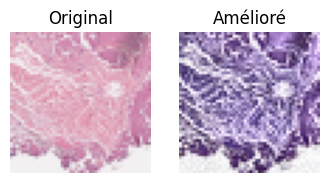

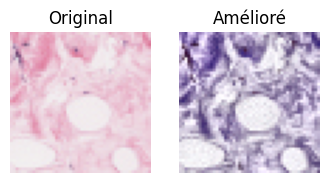

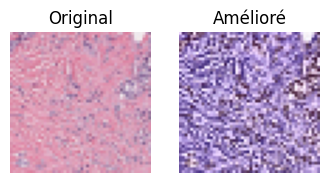

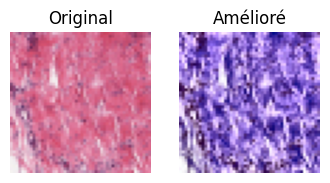

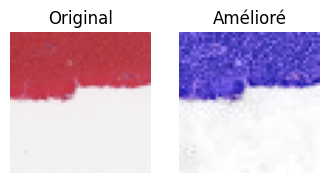

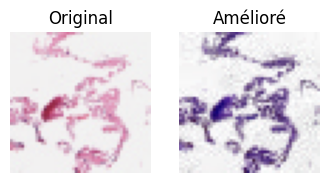

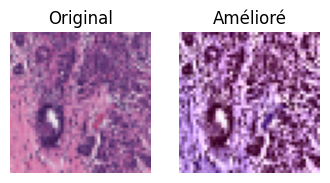

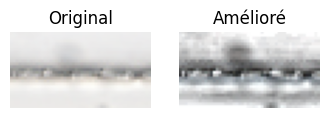

In [22]:
pix = dataloader.get_sample(10,0).values()
for p in pix:
    plot_clahe(p[0].array, clahe_transform(p[0].array))

In [23]:
from pinkribbon.dataset import build_pixels_dataframe

In [24]:
df = build_pixels_dataframe(dataloader, 1500)

In [25]:
df.head()

,classe,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,...,b_246,b_247,b_248,b_249,b_250,b_251,b_252,b_253,b_254,b_255
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [27]:
X = df.iloc[:,1:]
y  = df.iloc[:,0]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42, stratify=y)

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       300
           1       0.82      0.84      0.83       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



In [33]:
from sklearn.metrics import recall_score
recall_score(y_test,y_pred)

0.84

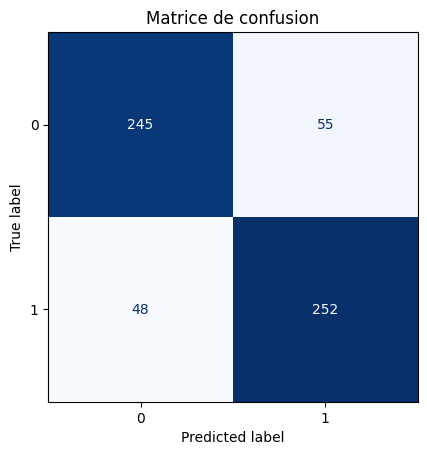

In [30]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues", colorbar=False)
plt.title("Matrice de confusion")
plt.show()

In [227]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2000
           1       0.81      0.80      0.81      2000

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



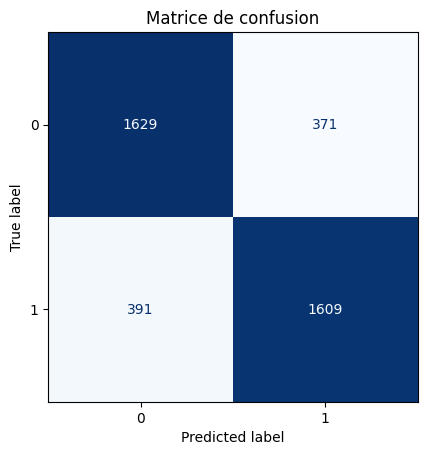

In [228]:
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="Blues", colorbar=False)
plt.title("Matrice de confusion")
plt.show()

In [229]:
lr =  LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap="Blues", colorbar=False)
plt.title("Matrice de confusion")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# 1. Prépare tes données X et y
# (X_train, X_test, y_train, y_test déjà créés)

# 2. Définir le modèle de base
rf = RandomForestClassifier(random_state=42)

# 3. Définir la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],          # nombre d'arbres
    'max_depth': [None, 10, 20, 30],         # profondeur max des arbres
    'min_samples_split': [2, 5, 10],         # nombre min d'échantillons pour splitter un noeud
    'min_samples_leaf': [1, 2, 4],           # nombre min d'échantillons dans une feuille
    'max_features': ['auto', 'sqrt', 'log2'] # nombre de features à considérer pour la recherche du split optimal
}

# 4. Initialiser GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,               # 5-fold cross validation
    n_jobs=-1,          # utilise tous les coeurs dispo
    verbose=2,          # affiche l’avancement
    scoring='accuracy'  # critère d’évaluation
)

# 5. Lancer la recherche sur les données d'entraînement
grid_search.fit(X_train, y_train)

# 6. Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# 7. Évaluer le meilleur modèle sur le test
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
